In [68]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [69]:
# Carrega o dataset completo com preços, geração, load, e clima
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)

# Verifica se a coluna de preço está presente
print(df.columns[df.columns.str.contains("price", case=False)])


Index(['price day ahead', 'price actual'], dtype='object')


In [70]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


In [71]:
def create_fixed_yearly_splits(df):
    """
    Cria 3 janelas fixas com treino e teste de 1 ano cada.
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    ranges = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
        ('2016-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),
        ('2017-01-01', '2017-12-31', '2018-01-01', '2018-12-31')
    ]

    for train_start, train_end, test_start, test_end in ranges:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits

splits = create_fixed_yearly_splits(df_prepared)

# Visualizar os períodos
for i, (train, test) in enumerate(splits, start=1):
    print(f"Janela {i}:")
    print(f"  Treino: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} registos)")
    print(f"  Teste:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} registos)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2016-01-01 → 2016-12-31  (8784 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2017-01-01 → 2017-12-31  (8760 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [72]:
forecast_horizon = 24  # ou 168 para longo prazo
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


In [74]:
def evaluate_model_across_splits(splits, model_type='lr', forecast_horizon=24):
    """
    Avalia um modelo em 3 janelas com várias métricas.
    """
    results = []

    for i, (df_train, df_test) in enumerate(splits, start=1):
        # Prepara features e target
        df_train = df_train.copy()
        df_test = df_test.copy()

        df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
        df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

        df_train.dropna(subset=['target'], inplace=True)
        df_test.dropna(subset=['target'], inplace=True)

        drop_cols = ['price actual', 'price day ahead', 'target']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['target'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['target'].values

        # Escolher o scaler adequado
        if model_type == 'lstm':
            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
        else:
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Escolher o modelo
        if model_type == 'lr':
            model = LinearRegression()
        elif model_type == 'rf':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_type == 'xgb':
            model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
        else:
            raise ValueError("Modelo não suportado.")

        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'janela': i,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return results


In [75]:
xgb_results = evaluate_model_across_splits(splits, model_type='xgb', forecast_horizon=168)

import pandas as pd
df_xgb = pd.DataFrame(xgb_results)
display(df_xgb)

# Linear Regression
lr_results = evaluate_model_across_splits(splits, model_type='lr', forecast_horizon=168)
df_lr = pd.DataFrame(lr_results)
display(df_lr)

# Random Forest
rf_results = evaluate_model_across_splits(splits, model_type='rf', forecast_horizon=168)
df_rf = pd.DataFrame(rf_results)
display(df_rf)



,janela,MAE,RMSE,MAPE (%),rMAE
0,1,13.799471,16.629015,40.197175,0.289723
1,2,6.405461,8.755751,11.368923,0.108381
2,3,6.545475,8.949137,13.109144,0.102603


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,12.776209,15.513166,36.386887,0.268239
1,2,5.992934,8.234128,11.166853,0.101401
2,3,7.231624,9.724990,14.202488,0.113358


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,12.779714,15.581631,37.805272,0.268313
1,2,6.519287,8.851344,11.669757,0.110307
2,3,6.016541,8.420669,12.197772,0.094312


In [76]:
def plot_real_vs_predicted(df_train, df_test, model_type='xgb', forecast_horizon=168, timesteps=24):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    df_train = df_train.copy()
    df_test = df_test.copy()

    # Add target column
    df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
    df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

    df_train.dropna(subset=['target'], inplace=True)
    df_test.dropna(subset=['target'], inplace=True)

    drop_cols = ['price actual', 'price day ahead', 'target']
    feature_cols = [col for col in df_train.columns if col not in drop_cols]

    X_train = df_train[feature_cols].values
    y_train = df_train['target'].values
    X_test = df_test[feature_cols].values
    y_test = df_test['target'].values

    # Choose scaler
    if model_type == 'lstm':
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
    else:
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

    # Train model
    if model_type == 'lr':
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)

    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)

    elif model_type == 'xgb':
        model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)

    elif model_type == 'lstm':
        # Build sequences
        def build_sequences(X, y, timesteps):
            X_seq, y_seq = [], []
            for i in range(timesteps, len(X)):
                X_seq.append(X[i - timesteps:i])
                y_seq.append(y[i])
            return np.array(X_seq), np.array(y_seq)

        X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        y_pred_scaled = model.predict(X_test_seq).ravel()
        y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

    else:
        raise ValueError("Unsupported model type")

    # Inverse transform predictions
    if model_type != 'lstm':
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    else:
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(y_test[:forecast_horizon], label='Actual')
    plt.plot(y_pred[:forecast_horizon], label='Predicted')
    plt.title(f'{model_type.upper()} – Real vs Predicted ({forecast_horizon}h)')
    plt.xlabel('Hour')
    plt.ylabel('Price (€)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


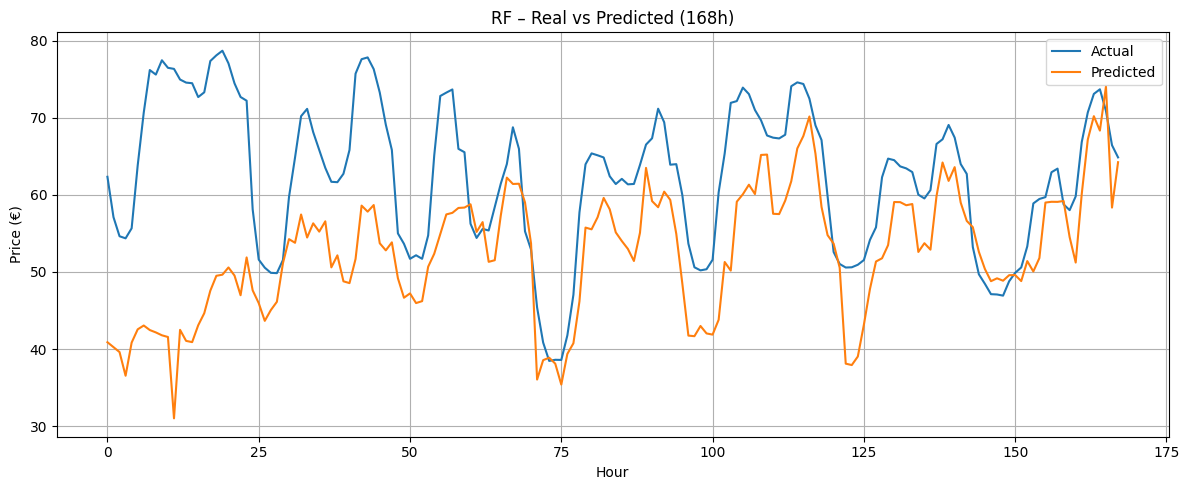

In [77]:
df_train, df_test = splits[2]  # Janela 3
plot_real_vs_predicted(df_train, df_test, model_type='rf', forecast_horizon=168)

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def tune_random_forest(splits, forecast_horizon=168):
    """
    Faz tuning leve do Random Forest com base nas 3 janelas fixas.
    Testa combinações simples de n_estimators e max_depth.
    Retorna tabela com média das métricas por configuração.
    """
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20]
    }

    results = []

    for n in param_grid['n_estimators']:
        for d in param_grid['max_depth']:
            maes, mapes, rmses, rmaes = [], [], [], []

            for df_train, df_test in splits:
                df_train = df_train.copy()
                df_test = df_test.copy()

                df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

                df_train.dropna(subset=['target'], inplace=True)
                df_test.dropna(subset=['target'], inplace=True)

                drop_cols = ['price actual', 'price day ahead', 'target']
                feature_cols = [col for col in df_train.columns if col not in drop_cols]

                X_train = df_train[feature_cols].values
                y_train = df_train['target'].values
                X_test = df_test[feature_cols].values
                y_test = df_test['target'].values

                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
                model.fit(X_train_scaled, y_train_scaled)
                y_pred_scaled = model.predict(X_test_scaled)
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                rmae = mae / np.mean(np.abs(y_test))

                maes.append(mae)
                rmses.append(rmse)
                mapes.append(mape)
                rmaes.append(rmae)

            results.append({
                'n_estimators': n,
                'max_depth': d,
                'MAE': np.mean(maes),
                'RMSE': np.mean(rmses),
                'MAPE (%)': np.mean(mapes),
                'rMAE': np.mean(rmaes)
            })

    return pd.DataFrame(results)

rf_tuning_results = tune_random_forest(splits)
display(rf_tuning_results)


,n_estimators,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,10,8.387829,10.916625,20.517570,0.156755
1,100,20,8.439006,10.955887,20.551324,0.157656
2,200,10,8.396766,10.914608,20.523251,0.156926
3,200,20,8.442393,10.953486,20.563549,0.157782


In [79]:
from xgboost import XGBRegressor

def tune_xgboost(splits, forecast_horizon=168):
    """
    Faz tuning leve do XGBoost com base nas 3 janelas fixas.
    Retorna média das métricas por combinação de hiperparâmetros.
    """
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [6, 8]
    }

    results = []

    for n in param_grid['n_estimators']:
        for lr in param_grid['learning_rate']:
            for d in param_grid['max_depth']:
                maes, mapes, rmses, rmaes = [], [], [], []

                for df_train, df_test in splits:
                    df_train = df_train.copy()
                    df_test = df_test.copy()

                    df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                    df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

                    df_train.dropna(subset=['target'], inplace=True)
                    df_test.dropna(subset=['target'], inplace=True)

                    drop_cols = ['price actual', 'price day ahead', 'target']
                    feature_cols = [col for col in df_train.columns if col not in drop_cols]

                    X_train = df_train[feature_cols].values
                    y_train = df_train['target'].values
                    X_test = df_test[feature_cols].values
                    y_test = df_test['target'].values

                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()
                    X_train_scaled = scaler_X.fit_transform(X_train)
                    X_test_scaled = scaler_X.transform(X_test)
                    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                    model = XGBRegressor(n_estimators=n, learning_rate=lr, max_depth=d, random_state=42)
                    model.fit(X_train_scaled, y_train_scaled)
                    y_pred_scaled = model.predict(X_test_scaled)
                    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                    rmae = mae / np.mean(np.abs(y_test))

                    maes.append(mae)
                    rmses.append(rmse)
                    mapes.append(mape)
                    rmaes.append(rmae)

                results.append({
                    'n_estimators': n,
                    'learning_rate': lr,
                    'max_depth': d,
                    'MAE': np.mean(maes),
                    'RMSE': np.mean(rmses),
                    'MAPE (%)': np.mean(mapes),
                    'rMAE': np.mean(rmaes)
                })

    return pd.DataFrame(results)

xgb_tuning_results = tune_xgboost(splits)
display(xgb_tuning_results)


,n_estimators,learning_rate,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,0.05,6,8.722027,11.259110,21.283755,0.163511
1,100,0.05,8,8.710895,11.261533,21.152055,0.162746
2,100,0.10,6,8.916803,11.444635,21.558414,0.166902
3,100,0.10,8,8.969084,11.520602,21.760450,0.167809
4,200,0.05,6,8.848607,11.380299,21.531782,0.165876
5,200,0.05,8,8.753945,11.311040,21.223589,0.163460
6,200,0.10,6,9.048125,11.571811,21.755141,0.169110
7,200,0.10,8,8.991113,11.542660,21.781495,0.168119


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def evaluate_lstm_on_splits(splits, forecast_horizon=168, timesteps=24, units=50, batch_size=32, epochs=10):
    results = []

    for i, (df_train, df_test) in enumerate(splits, start=1):
        df_train = df_train.copy()
        df_test = df_test.copy()

        df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
        df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

        df_train.dropna(subset=['target'], inplace=True)
        df_test.dropna(subset=['target'], inplace=True)

        drop_cols = ['price actual', 'price day ahead', 'target']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['target'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['target'].values

        # Normalização com MinMaxScaler
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Criação das sequências para LSTM
        def build_sequences(X, y, timesteps):
            Xs, ys = [], []
            for i in range(timesteps, len(X)):
                Xs.append(X[i - timesteps:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

        # Modelo LSTM
        model = Sequential()
        model.add(LSTM(units, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        y_pred_scaled = model.predict(X_test_seq).ravel()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

        # Métricas
        mae = mean_absolute_error(y_test_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
        mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test_real))

        results.append({
            'janela': i,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return results

lstm_results = evaluate_lstm_on_splits(splits, forecast_horizon=168)
df_lstm = pd.DataFrame(lstm_results)
display(df_lstm)


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,14.642084,17.521945,40.879195,0.307338
1,2,6.640551,9.076352,12.224174,0.112402
2,3,10.039533,12.208240,17.600021,0.157423


In [81]:
def tune_lstm(splits, forecast_horizon=168, timesteps=24, epochs=10):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np

    param_grid = {
        'units': [50, 100],
        'batch_size': [16, 32]
    }

    results = []

    for units in param_grid['units']:
        for batch_size in param_grid['batch_size']:
            maes, mapes, rmses, rmaes = [], [], [], []

            for df_train, df_test in splits:
                df_train = df_train.copy()
                df_test = df_test.copy()

                df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

                df_train.dropna(subset=['target'], inplace=True)
                df_test.dropna(subset=['target'], inplace=True)

                drop_cols = ['price actual', 'price day ahead', 'target']
                feature_cols = [col for col in df_train.columns if col not in drop_cols]

                X_train = df_train[feature_cols].values
                y_train = df_train['target'].values
                X_test = df_test[feature_cols].values
                y_test = df_test['target'].values

                scaler_X = MinMaxScaler()
                scaler_y = MinMaxScaler()
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                # Sequências
                def build_sequences(X, y, timesteps):
                    Xs, ys = [], []
                    for i in range(timesteps, len(X)):
                        Xs.append(X[i - timesteps:i])
                        ys.append(y[i])
                    return np.array(Xs), np.array(ys)

                X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
                X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

                model = Sequential()
                model.add(LSTM(units, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

                y_pred_scaled = model.predict(X_test_seq).ravel()
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
                y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

                mae = mean_absolute_error(y_test_real, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
                mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
                rmae = mae / np.mean(np.abs(y_test_real))

                maes.append(mae)
                rmses.append(rmse)
                mapes.append(mape)
                rmaes.append(rmae)

            results.append({
                'units': units,
                'batch_size': batch_size,
                'MAE': np.mean(maes),
                'RMSE': np.mean(rmses),
                'MAPE (%)': np.mean(mapes),
                'rMAE': np.mean(rmaes)
            })

    return pd.DataFrame(results)

lstm_tuning_results = tune_lstm(splits)
display(lstm_tuning_results)


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,units,batch_size,MAE,RMSE,MAPE (%),rMAE
0,50,16,10.571618,13.079533,23.939418,0.193487
1,50,32,8.886093,11.413753,19.987927,0.162951
2,100,16,9.763698,12.325027,22.537141,0.180178
3,100,32,11.270194,13.751645,25.819294,0.210355


In [82]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Função do teste (como antes)
def diebold_mariano_manual(e1, e2, h=1):
    d = e1 - e2
    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)
    n = len(d)
    DM_stat = d_mean / np.sqrt(d_var / n)
    from scipy.stats import t
    p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n - 1))
    return DM_stat, p_value

# ============
# PREPARAÇÃO
# ============
df_train, df_test = splits[2]  # Janela 3
df_train = df_train.copy()
df_test = df_test.copy()
forecast_horizon = 168

df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
df_train.dropna(subset=['target'], inplace=True)
df_test.dropna(subset=['target'], inplace=True)

drop_cols = ['price actual', 'price day ahead', 'target']
feature_cols = [col for col in df_train.columns if col not in drop_cols]

X_train = df_train[feature_cols].values
y_train = df_train['target'].values
X_test = df_test[feature_cols].values
y_test = df_test['target'].values

# ============
# XGBOOST
# ============
scaler_X_xgb = StandardScaler()
scaler_y_xgb = StandardScaler()
X_train_xgb = scaler_X_xgb.fit_transform(X_train)
X_test_xgb = scaler_X_xgb.transform(X_test)
y_train_xgb = scaler_y_xgb.fit_transform(y_train.reshape(-1, 1)).ravel()

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb_scaled = model_xgb.predict(X_test_xgb)
y_pred_xgb = scaler_y_xgb.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).ravel()

# ============
# LSTM
# ============
scaler_X_lstm = MinMaxScaler()
scaler_y_lstm = MinMaxScaler()
X_train_lstm = scaler_X_lstm.fit_transform(X_train)
X_test_lstm = scaler_X_lstm.transform(X_test)
y_train_lstm = scaler_y_lstm.fit_transform(y_train.reshape(-1, 1)).ravel()

# Função para criar sequências
def build_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i - timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = build_sequences(X_train_lstm, y_train_lstm, timesteps=24)
X_test_seq, y_test_seq = build_sequences(X_test_lstm, scaler_y_lstm.transform(y_test.reshape(-1, 1)).ravel(), timesteps=24)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(24, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

y_pred_lstm_scaled = model_lstm.predict(X_test_seq).ravel()
y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y_lstm.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

# ============
# DIEBOLD-MARIANO TEST
# ============
e_xgb = np.abs(y_true - y_pred_xgb[-len(y_true):])  # alinhar tamanhos
e_lstm = np.abs(y_true - y_pred_lstm)

dm_stat, p_val = diebold_mariano_manual(e_lstm, e_xgb, h=1)
print(f"📊 Diebold-Mariano Statistic: {dm_stat:.4f}")
print(f"📌 p-value: {p_val:.4f}")


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
📊 Diebold-Mariano Statistic: 35.6180
📌 p-value: 0.0000


In [83]:
# Avaliar modelos com short-term horizon (24h)
lr_short = evaluate_model_across_splits(splits, model_type='lr', forecast_horizon=24)
rf_short = evaluate_model_across_splits(splits, model_type='rf', forecast_horizon=24)
xgb_short = evaluate_model_across_splits(splits, model_type='xgb', forecast_horizon=24)

# Converter para DataFrames e visualizar
import pandas as pd
df_lr_short = pd.DataFrame(lr_short)
df_rf_short = pd.DataFrame(rf_short)
df_xgb_short = pd.DataFrame(xgb_short)

display(df_lr_short)
display(df_rf_short)
display(df_xgb_short)


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,7.957580,10.011144,22.501569,0.167673
1,2,5.432815,7.269426,9.934683,0.091588
2,3,5.850958,7.586063,11.058253,0.092054


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,10.471912,13.029550,30.478953,0.220652
1,2,5.329747,7.577350,9.257782,0.089850
2,3,5.204729,7.048966,10.388009,0.081887


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,10.233174,12.760701,29.841585,0.215622
1,2,5.385594,7.638750,9.321094,0.090791
2,3,5.348389,7.300667,10.742070,0.084147


In [84]:
def tune_random_forest_short(splits, forecast_horizon=24):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import pandas as pd

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20]
    }

    results = []

    for n in param_grid['n_estimators']:
        for d in param_grid['max_depth']:
            maes, rmses, mapes, rmaes = [], [], [], []

            for df_train, df_test in splits:
                df_train = df_train.copy()
                df_test = df_test.copy()
                df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
                df_train.dropna(subset=['target'], inplace=True)
                df_test.dropna(subset=['target'], inplace=True)

                drop_cols = ['price actual', 'price day ahead', 'target']
                feature_cols = [col for col in df_train.columns if col not in drop_cols]

                X_train = df_train[feature_cols].values
                y_train = df_train['target'].values
                X_test = df_test[feature_cols].values
                y_test = df_test['target'].values

                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
                model.fit(X_train_scaled, y_train_scaled)
                y_pred_scaled = model.predict(X_test_scaled)
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                rmae = mae / np.mean(np.abs(y_test))

                maes.append(mae)
                rmses.append(rmse)
                mapes.append(mape)
                rmaes.append(rmae)

            results.append({
                'n_estimators': n,
                'max_depth': d,
                'MAE': np.mean(maes),
                'RMSE': np.mean(rmses),
                'MAPE (%)': np.mean(mapes),
                'rMAE': np.mean(rmaes)
            })

    return pd.DataFrame(results)


In [85]:
def tune_xgboost_short(splits, forecast_horizon=24):
    from xgboost import XGBRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [6, 8]
    }

    results = []

    for n in param_grid['n_estimators']:
        for lr in param_grid['learning_rate']:
            for d in param_grid['max_depth']:
                maes, rmses, mapes, rmaes = [], [], [], []

                for df_train, df_test in splits:
                    df_train = df_train.copy()
                    df_test = df_test.copy()
                    df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                    df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
                    df_train.dropna(subset=['target'], inplace=True)
                    df_test.dropna(subset=['target'], inplace=True)

                    drop_cols = ['price actual', 'price day ahead', 'target']
                    feature_cols = [col for col in df_train.columns if col not in drop_cols]

                    X_train = df_train[feature_cols].values
                    y_train = df_train['target'].values
                    X_test = df_test[feature_cols].values
                    y_test = df_test['target'].values

                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()
                    X_train_scaled = scaler_X.fit_transform(X_train)
                    X_test_scaled = scaler_X.transform(X_test)
                    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                    model = XGBRegressor(n_estimators=n, learning_rate=lr, max_depth=d, random_state=42)
                    model.fit(X_train_scaled, y_train_scaled)
                    y_pred_scaled = model.predict(X_test_scaled)
                    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                    rmae = mae / np.mean(np.abs(y_test))

                    maes.append(mae)
                    rmses.append(rmse)
                    mapes.append(mape)
                    rmaes.append(rmae)

                results.append({
                    'n_estimators': n,
                    'learning_rate': lr,
                    'max_depth': d,
                    'MAE': np.mean(maes),
                    'RMSE': np.mean(rmses),
                    'MAPE (%)': np.mean(mapes),
                    'rMAE': np.mean(rmaes)
                })

    return pd.DataFrame(results)


In [86]:
rf_tuning_short = tune_random_forest_short(splits, forecast_horizon=24)
display(rf_tuning_short)

xgb_tuning_short = tune_xgboost_short(splits, forecast_horizon=24)
display(xgb_tuning_short)

lstm_tuning_short = tune_lstm(splits, forecast_horizon=24)
display(lstm_tuning_short)

,n_estimators,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,10,7.019253,9.256496,16.839805,0.131325
1,100,20,6.986324,9.208311,16.665619,0.130450
2,200,10,6.989734,9.226858,16.774761,0.130761
3,200,20,6.969730,9.188223,16.640560,0.130185


,n_estimators,learning_rate,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,0.05,6,6.944378,9.201390,16.712527,0.129554
1,100,0.05,8,6.987618,9.222759,16.617511,0.130088
2,100,0.10,6,6.989052,9.233372,16.634916,0.130187
3,100,0.10,8,7.114110,9.326786,16.810336,0.132563
4,200,0.05,6,6.884400,9.114542,16.425533,0.128140
5,200,0.05,8,6.976331,9.192232,16.521931,0.129813
6,200,0.10,6,7.086756,9.304382,16.751861,0.131963
7,200,0.10,8,7.123263,9.328684,16.781062,0.132642


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


,units,batch_size,MAE,RMSE,MAPE (%),rMAE
0,50,16,8.697162,10.747024,19.281607,0.161065
1,50,32,8.401048,10.494052,18.842523,0.154796
2,100,16,9.144078,11.103942,20.223105,0.169004
3,100,32,9.310812,11.253589,20.402354,0.172358


In [87]:
def evaluate_lstm_on_splits(splits, forecast_horizon=24, timesteps=24, units=50, batch_size=32, epochs=10):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    results = []

    for i, (df_train, df_test) in enumerate(splits, start=1):
        df_train = df_train.copy()
        df_test = df_test.copy()
        df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
        df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
        df_train.dropna(subset=['target'], inplace=True)
        df_test.dropna(subset=['target'], inplace=True)

        drop_cols = ['price actual', 'price day ahead', 'target']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['target'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['target'].values

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        def build_sequences(X, y, timesteps):
            Xs, ys = [], []
            for i in range(timesteps, len(X)):
                Xs.append(X[i - timesteps:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

        model = Sequential()
        model.add(LSTM(units, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        y_pred_scaled = model.predict(X_test_seq).ravel()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

        from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
        mae = mean_absolute_error(y_test_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
        mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test_real))

        results.append({
            'janela': i,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return results


In [88]:
lstm_short = evaluate_lstm_on_splits(splits, forecast_horizon=24)
df_lstm_short = pd.DataFrame(lstm_short)
display(df_lstm_short)


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,12.542110,15.002671,35.206426,0.264194
1,2,6.439907,9.405893,11.096661,0.108612
2,3,7.581944,9.427173,13.678123,0.119206


In [89]:
# 1. Obter dados da janela 3
df_train, df_test = splits[2]  # janela 3
df_test = df_test.copy()
df_test['target'] = df_test['price actual'].shift(-24)
df_test.dropna(subset=['target'], inplace=True)

# Features
drop_cols = ['price actual', 'price day ahead', 'target']
feature_cols = [col for col in df_test.columns if col not in drop_cols]
X_test = df_test[feature_cols]
y_true = df_test['target'].values

# 2. StandardScaler (igual ao usado nos modelos tradicionais)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = splits[2][0][feature_cols]
y_train = splits[2][0]['price actual'].shift(-24).dropna()
X_train = X_train.loc[y_train.index]
scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)

# 3. Re-treinar XGBoost (modelo base)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_test)

# 4. Re-treinar LSTM (modelo base)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# MinMax para LSTM
scaler_X_lstm = MinMaxScaler()
scaler_y_lstm = MinMaxScaler()

X_train_lstm = scaler_X_lstm.fit_transform(X_train)
y_train_lstm = scaler_y_lstm.fit_transform(y_train.values.reshape(-1, 1)).ravel()
X_test_lstm = scaler_X_lstm.transform(X_test)

# Sequências
def build_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(24, len(X)):
        Xs.append(X[i - 24:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = build_sequences(X_train_lstm, y_train_lstm)
X_test_seq, y_test_seq = build_sequences(X_test_lstm, scaler_y_lstm.transform(y_true.reshape(-1, 1)).ravel())

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(24, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

y_lstm_scaled = model_lstm.predict(X_test_seq).ravel()
y_lstm = scaler_y_lstm.inverse_transform(y_lstm_scaled.reshape(-1, 1)).ravel()


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [90]:
min_len = min(len(y_xgb), len(y_lstm), len(y_true))

e_xgb = np.abs(y_true[-min_len:] - y_xgb[-min_len:])
e_lstm = np.abs(y_true[-min_len:] - y_lstm[-min_len:])

dm_stat, p_val = diebold_mariano_manual(e_xgb, e_lstm)
print(f"📊 Diebold-Mariano Statistic: {dm_stat:.4f}")
print(f"📌 p-value: {p_val:.4f}")


📊 Diebold-Mariano Statistic: -42.0804
📌 p-value: 0.0000


In [91]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ⚠️ Atualizar esta lista de features (sem 'target')
feature_cols = [col for col in train_X.columns if col != 'target']

# Treinar o modelo com as features corretas
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(train_X[feature_cols], train_y)

xgb_predictions = []

# Debugging info (pode remover depois)
print("Train shape:", train_X[feature_cols].shape)
print("Latest input shape:", latest_input[feature_cols].shape)
print("Missing columns?", set(train_X[feature_cols].columns) - set(latest_input.columns))

# Gerar previsões passo a passo
for step in range(24):
    input_scaled = scaler_X.transform(latest_input[feature_cols])
    pred_scaled = xgb_model.predict(input_scaled[-1:])
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
    xgb_predictions.append(pred)

    # Atualizar a sequência de entrada
    next_row = latest_input.iloc[-1:].copy()
    next_row['lag_1h'] = pred
    next_row['lag_24h'] = latest_input.iloc[-24]['lag_1h']

    next_row['hour'] = (next_row['hour'] + 1) % 24
    next_row['hour_sin'] = np.sin(2 * np.pi * next_row['hour'] / 24)
    next_row['hour_cos'] = np.cos(2 * np.pi * next_row['hour'] / 24)
    next_row['day_of_week'] = (next_row['day_of_week'] + (next_row['hour'] == 0).astype(int)) % 7
    next_row['dow_sin'] = np.sin(2 * np.pi * next_row['day_of_week'] / 7)
    next_row['dow_cos'] = np.cos(2 * np.pi * next_row['day_of_week'] / 7)

    latest_input = pd.concat([latest_input.iloc[1:], next_row])


Train shape: (35016, 78)
Latest input shape: (24, 78)
Missing columns? set()


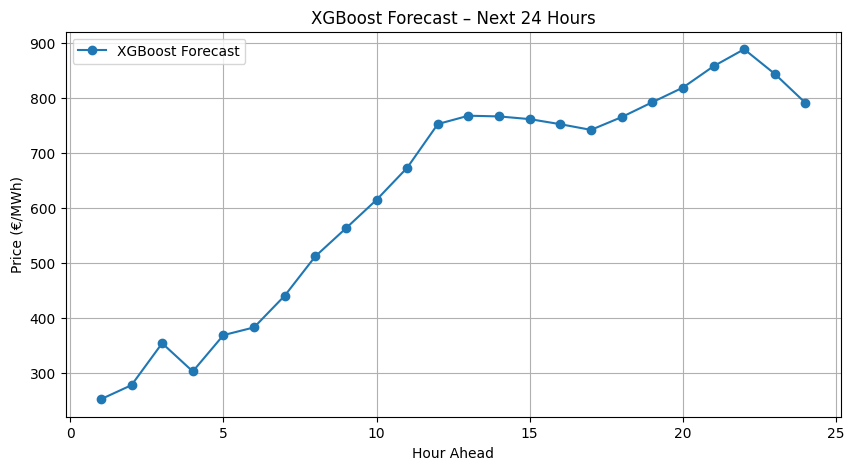

In [92]:
# Visualização
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), xgb_predictions, marker='o', label='XGBoost Forecast')
plt.title("XGBoost Forecast – Next 24 Hours")
plt.xlabel("Hour Ahead")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.legend()
plt.show()


In [93]:
# Copiar últimos 24 pontos válidos
latest_df = df_prepared.dropna().copy()
latest_input = latest_df.iloc[-24:].copy()

# Features
drop_cols = ['price actual', 'price day ahead']
feature_cols = [col for col in latest_input.columns if col not in drop_cols]

# Reajustar scalers com treino recente (opcional mas seguro)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
train_X = df_prepared[feature_cols]
train_y = df_prepared['price actual']

scaler_X.fit(train_X)
scaler_y.fit(train_y.values.reshape(-1, 1))


StandardScaler()

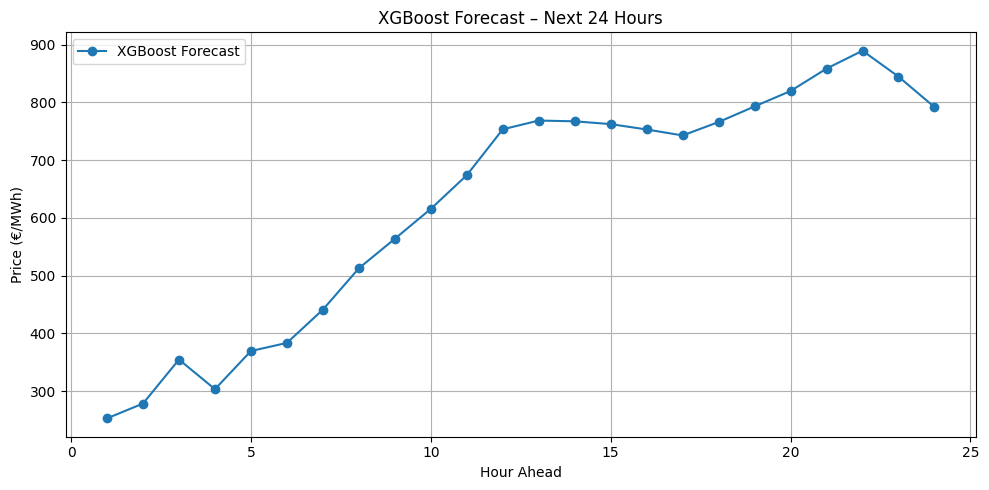

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), xgb_predictions, marker='o', label='XGBoost Forecast')
plt.xlabel('Hour Ahead')
plt.ylabel('Price (€/MWh)')
plt.title('XGBoost Forecast – Next 24 Hours')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
